In [1]:
import torch
import torch.nn as nn
import string

%matplotlib inline

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

import copy
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import transforms

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(string.ascii_letters))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

Using cache found in /home/kacper/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
WIDTH = 400

def generate_sample(batch_size=4, preprocess=None):
    imgs = []
    letters = []

    for i in range(batch_size):
        img = np.zeros((WIDTH, WIDTH, 3), dtype=np.uint8)
        
        bg = np.random.randint(0, 255, size=3, dtype=np.uint8)
        img += bg
        
        font = ImageFont.truetype("../figure-generator/assets/RammettoOne-Regular.ttf", int(120))
        letter = random.choice(string.ascii_letters)
        letters.append(letter)

        image = Image.fromarray(img)
        draw = ImageDraw.Draw(image)
        
        color = tuple(np.random.randint(0, 255, size=3))
        draw.text((WIDTH//2-60, WIDTH//2-90), letter, font=font, fill=color, align="center")

        random_angle = random.randint(0,360)
        image = image.rotate(random_angle)

        img = np.array(image, dtype=np.uint8)
        
        img = img[100:300,100:300]
        
        img = Image.fromarray(img)
        
        if preprocess is not None:
            img = preprocess(img)
        else:
            img = transforms.ToTensor()(img)

        imgs.append(img)
        
    return torch.stack(imgs), letters

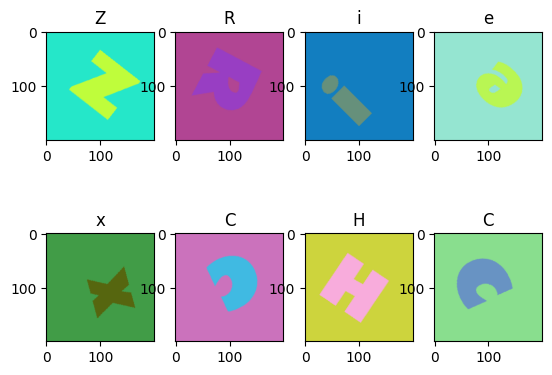

In [47]:
imgs, labels = generate_sample(8)

for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(2, 4, i+1)
    plt.title(label)
    plt.imshow(img.permute((1,2,0)))

In [48]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def generator(n=1000, batch_size=4):
    for i in range(n):
        imgs, labels = generate_sample(batch_size, preprocess)
        
        # charachter to id
        labels_ids = [string.ascii_letters.index(l) for l in labels]

        yield imgs, torch.tensor(labels_ids)

In [49]:
batch_size = 16

total = {
    "train": 1000,
    "val": 200,
}

num_epochs = 5
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

best_acc = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        # pbar = tqdm(total=database_size)
        with tqdm(total=total[phase]) as pbar:
            pbar.set_description(phase)
            for inputs, labels in generator(total[phase], batch_size=batch_size):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.update()

            epoch_loss = running_loss / (total[phase] * batch_size)
            epoch_acc = running_corrects.double() / (total[phase] * batch_size)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    print()

Epoch 0/4
----------


  0%|          | 0/1000 [00:00<?, ?it/s]

train Loss: 0.0440 Acc: 0.9886


  0%|          | 0/200 [00:00<?, ?it/s]

val Loss: 0.0123 Acc: 0.9962

Epoch 1/4
----------


  0%|          | 0/1000 [00:00<?, ?it/s]

train Loss: 0.0426 Acc: 0.9891


  0%|          | 0/200 [00:00<?, ?it/s]

val Loss: 0.0388 Acc: 0.9850

Epoch 2/4
----------


  0%|          | 0/1000 [00:00<?, ?it/s]

train Loss: 0.0077 Acc: 0.9976


  0%|          | 0/200 [00:00<?, ?it/s]

val Loss: 0.0002 Acc: 1.0000

Epoch 3/4
----------


  0%|          | 0/1000 [00:00<?, ?it/s]

train Loss: 0.0237 Acc: 0.9949


  0%|          | 0/200 [00:00<?, ?it/s]

val Loss: 0.0006 Acc: 1.0000

Epoch 4/4
----------


  0%|          | 0/1000 [00:00<?, ?it/s]

train Loss: 0.0324 Acc: 0.9919


  0%|          | 0/200 [00:00<?, ?it/s]

val Loss: 0.0032 Acc: 0.9994



In [50]:
torch.save(model.state_dict(), 'model_weights.pth')

In [51]:
model.eval()

valid = 0
total = 1000

with tqdm(total=total) as pbar:
    for imgs, labels in generator(n=total, batch_size=1):
        imgs = imgs.to(device)
        outputs = model(imgs)

        if labels.numpy()[0] == outputs.cpu().detach().numpy().argmax():
            valid += 1
        pbar.update()
        
print(valid/total)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.0


In [52]:
img = Image.open("runs/detect/exp2/crops/circle/ea35012a-bf33-11ed-aca4-899b60ca7768.jpg")
img = preprocess(img)
img = torch.unsqueeze(img, 0)

img = img.to(device)

outputs = model(img)

string.ascii_letters[outputs.cpu().detach().numpy().argmax()]

'A'